In [37]:
%matplotlib inline

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import datetime
import tensorflow as tf

In [39]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [40]:
TRAIN_SPLIT = 24

In [41]:
data = pd.read_csv('월별공급량및비중.csv')
data["ID"] = pd.date_range("1996-01-01", "1998-12-01", freq="MS")

In [42]:
civil = data["도시가스(톤)_민수용"]
civil.index = data["ID"]
print(civil.head())

ID
1996-01-01    605519.0
1996-02-01    566323.0
1996-03-01    477514.0
1996-04-01    337794.0
1996-05-01    184522.0
Name: 도시가스(톤)_민수용, dtype: float64


array([<AxesSubplot:xlabel='ID'>], dtype=object)

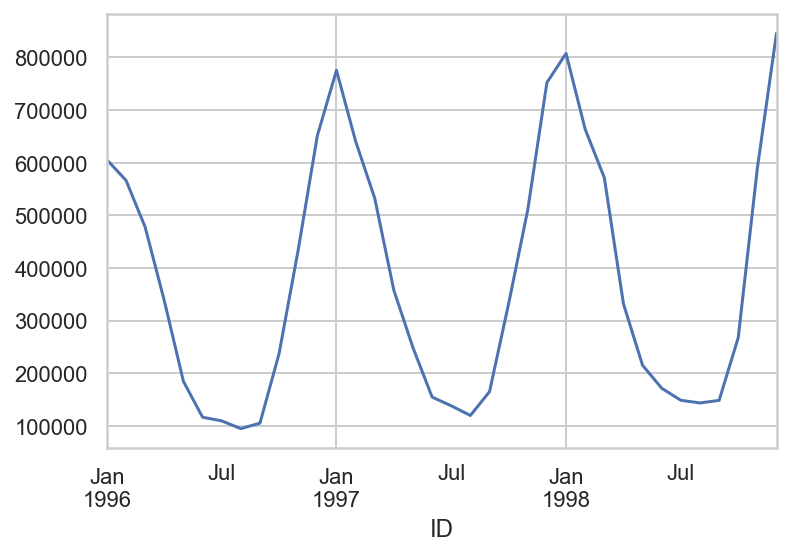

In [43]:
civil.plot(subplots=True)

In [44]:
civil = civil.values

In [45]:
civil_train_mean = civil[:TRAIN_SPLIT].mean()
civil_train_std = civil[:TRAIN_SPLIT].std()
civil = (civil-civil_train_mean)/civil_train_std

In [46]:
civil_past_history=12
civil_future_target=0
x_train, y_train = univariate_data(civil, 0, TRAIN_SPLIT, civil_past_history, civil_future_target)
x_val, y_val = univariate_data(civil, TRAIN_SPLIT, None, civil_past_history, civil_future_target)

In [47]:
print('Single window of past history')
print(x_train[0])
print('\n Target to predict')
print(y_train[0])

Single window of past history
[[ 1.1110578 ]
 [ 0.93345596]
 [ 0.53105159]
 [-0.1020367 ]
 [-0.79653076]
 [-1.10512732]
 [-1.13658236]
 [-1.20336203]
 [-1.15620665]
 [-0.55761831]
 [ 0.33575572]
 [ 1.31817989]]

 Target to predict
1.881362044883948


In [48]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [49]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [51]:
for x, y in val_univariate.take(1):
    print(x,y)
    print(simple_lstm_model.predict(x).shape)

In [30]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data=val_univariate, validation_steps=50)

Epoch 1/10
195/200 [============================>.] - ETA: 0s - loss: 0.5881WARNING:tensorflow:Model was constructed with shape (None, 12, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name='lstm_1_input'), name='lstm_1_input', description="created by layer 'lstm_1_input'"), but it was called on an input with incompatible shape (None,).


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_1" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_1" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float64)
      • training=False
      • mask=None
